In [ ]:
!pip install kaggle

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import kagglehub
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
import skimage.io as io

import random
from collections import defaultdict
from typing import List, Tuple

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Download latest version
path = kagglehub.dataset_download("wildlifedatasets/seaturtleid2022")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'seaturtleid2022' dataset.
Path to dataset files: /kaggle/input/seaturtleid2022


In [ ]:
root = os.path.join(path, "turtles-data", "data")
data_csv = os.path.join(path, "turtles-data", "data", "metadata_splits.csv")

# Load the split file into a DataFrame
df = pd.read_csv(data_csv)
df.head()

,id,width,height,file_name,timestamp,identity,date,year,split_closed,split_closed_random,split_open,clarity
0,1,2000,1333,images/t001/CAluWEgwPX.JPG,2014-07-14 14:49:45,t001,2014-07-14,2014,test,test,train,3
1,2,2000,1333,images/t001/EKyrFKHQzh.JPG,2014-07-14 14:48:49,t001,2014-07-14,2014,test,train,train,2
2,3,2000,1333,images/t001/ELAvEqeXxT.JPG,2014-07-14 14:49:48,t001,2014-07-14,2014,test,train,train,2
3,4,2000,1124,images/t001/IxRLFwTGCv.JPG,2010-07-02 14:09:40,t001,2010-07-02,2010,train,test,train,3
4,5,2000,1333,images/t001/LKCJAhfLBJ.JPG,2014-07-14 14:48:28,t001,2014-07-14,2014,test,test,train,4


In [ ]:
annotations_path = os.path.join(path, "turtles-data", "data", "annotations.json")

coco = COCO(annotations_path)

loading annotations into memory...
Done (t=12.83s)
creating index...
index created!


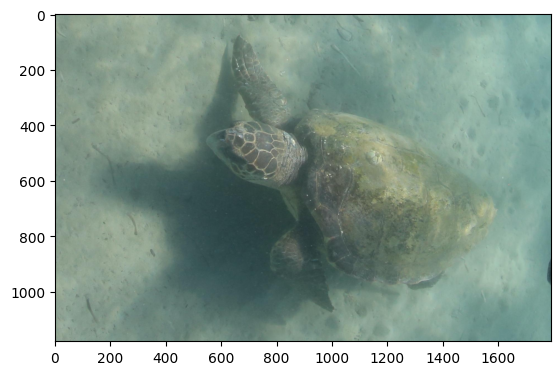

In [ ]:
# display example image
im_id = 4797
im = coco.loadImgs(im_id)[0]
fname = os.path.join(root, im['file_name'])
I = io.imread(fname)
plt.imshow(I)
plt.show()

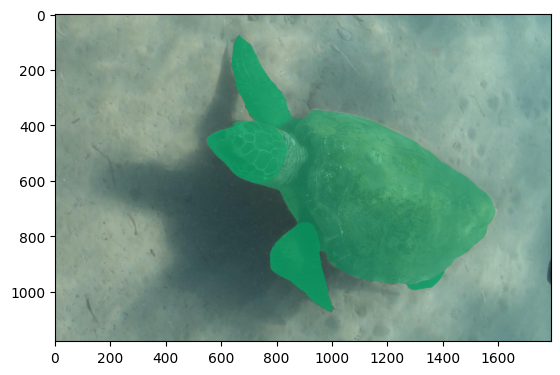

In [ ]:
# overlay image with annotation
plt.imshow(I)
cat_ids = coco.getCatIds()
ann_ids = coco.getAnnIds(imgIds=im['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(ann_ids)
coco.showAnns(anns)

In [ ]:
ALL_CLASSES = ['background', 'turtle', 'flipper', 'head']
NO_CLASSES = 4

# colour coding
COLOUR_CODING = np.array([
    [0, 0, 0],      # void -> black
    [255, 0, 0],    # turtle -> red
    [0, 255, 0],    # flipper -> green
    [0, 0, 255]     # head -> blue
])
def get_image_mask(image_id):
    cat_ids = coco.getCatIds()
    ann_ids = coco.getAnnIds(imgIds=image_id, catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((coco.imgs[image_id]['height'], coco.imgs[image_id]['width']), dtype=int)
    for ann in anns:
        submask = coco.annToMask(ann)
        mask = np.maximum(mask, submask * ann['category_id'])
    return mask

def get_category_counts(mask):
    unique, counts = np.unique(mask, return_counts=True)
    value_counts = dict(zip(unique.tolist(), counts.tolist()))
    return value_counts

No of masks:  5
{0: 1653163, 1: 335391, 2: 79153, 3: 45673}


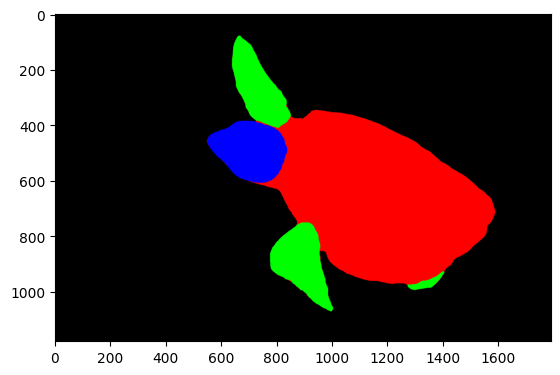

In [ ]:
# create mask
print("No of masks: ", len(anns))
mask = get_image_mask(im_id)
plt.imshow(COLOUR_CODING[mask])
print(get_category_counts(mask))

In [ ]:
DATASET_ROOT = root
ANNOTATIONS = annotations_path
SPLIT_CSV = data_csv
NUM_PARTS = 3
PART_NAMES = ['turtle', 'flipper', 'head']
IMG_SIZE = 256
PART_SIZE = 224
EMB_DIM = 256
BATCH_P = 8
BATCH_K = 4
BATCH_SIZE = BATCH_P * BATCH_K
NUM_WORKERS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class TurtleSegmentDataset(Dataset):
    def __init__(self, df, coco, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.coco = coco
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.df['label'] = self.label_encoder.fit_transform(self.df['identity'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.root_dir, row["file_name"])
        image_id = int(row["id"])

        image = Image.open(image_path).convert("RGB")
        mask = get_image_mask(image_id)

        segments = {}
        for i, seg_name in enumerate(['turtle', 'flipper', 'head'], start=1):
            seg_mask = (mask == i).astype(np.uint8)
            if seg_mask.sum() == 0:
                crop = image
            else:
                ys, xs = np.where(seg_mask > 0)
                crop = image.crop((xs.min(), ys.min(), xs.max(), ys.max()))
            if self.transform:
                crop = self.transform(crop)
            segments[seg_name] = crop

        label = torch.tensor(row["label"], dtype=torch.long)
        return segments, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_df = df[df['split_open'] == 'train']
test_df = df[df['split_open'] == 'test']

train_dataset = TurtleSegmentDataset(train_df, coco, root, transform)
test_dataset = TurtleSegmentDataset(test_df, coco, root, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


In [ ]:
class SegmentEmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        base.fc = nn.Linear(base.fc.in_features, embedding_dim)
        self.model = base

    def forward(self, x):
        return self.model(x)

In [ ]:
class TurtleReIDModel(nn.Module):
    def __init__(self, embedding_dim=128, num_classes=None):
        super().__init__()
        self.head_net = SegmentEmbeddingNet(embedding_dim)
        self.shell_net = SegmentEmbeddingNet(embedding_dim)
        self.flipper_net = SegmentEmbeddingNet(embedding_dim)
        combined_dim = embedding_dim * 3
        self.classifier = nn.Linear(combined_dim, num_classes)

    def forward(self, segments):
        head_emb = self.head_net(segments['head'])
        shell_emb = self.shell_net(segments['turtle'])
        flipper_emb = self.flipper_net(segments['flipper'])
        combined = torch.cat([head_emb, shell_emb, flipper_emb], dim=1)
        out = self.classifier(combined)
        return out, combined


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = df['identity'].nunique()

model = TurtleReIDModel(embedding_dim=128, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for segments, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        for k in segments:
            segments[k] = segments[k].to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(segments)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss / len(train_loader):.4f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]
Epoch 1/5: 100%|██████████| 663/663 [1:17:04<00:00,  6.98s/it]


Epoch 1/5 | Loss: 4.8349


Epoch 2/5: 100%|██████████| 663/663 [1:17:32<00:00,  7.02s/it]


Epoch 2/5 | Loss: 2.9618


Epoch 3/5: 100%|██████████| 663/663 [1:17:39<00:00,  7.03s/it]


Epoch 3/5 | Loss: 1.4171


Epoch 4/5: 100%|██████████| 663/663 [1:18:00<00:00,  7.06s/it]


Epoch 4/5 | Loss: 0.4732


Epoch 5/5: 100%|██████████| 663/663 [1:19:34<00:00,  7.20s/it]

Epoch 5/5 | Loss: 0.1372


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for segments, labels in test_loader:
        for k in segments:
            segments[k] = segments[k].to(device)
        labels = labels.to(device)
        outputs, _ = model(segments)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
acc = 100 * correct / total
print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 0.22%
